In [36]:
import pydrake
import meshcat
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
import matplotlib.pyplot as plt
import numpy as np, time, math, pydot
from pydrake.all import *
from pydrake.multibody.jupyter_widgets import MakeJointSlidersThatPublishOnCallback
from IPython.display import display, HTML, SVG

In [49]:
class JointController(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("State",BasicVector(18))
        self.DeclareVectorOutputPort("DesiredPosition", BasicVector(18), self.CalcOutput)
        self.t = 0
    
    def CalcOutput(self, context: Context, output: BasicVector):
        state = self.get_input_port().Eval(context)
        if self.t == 0:
            print(state)
            self.t += 1
        dx = np.zeros(18)
        dx[13] = 1
        nState = state + dx
        output.SetFromVector(nState)

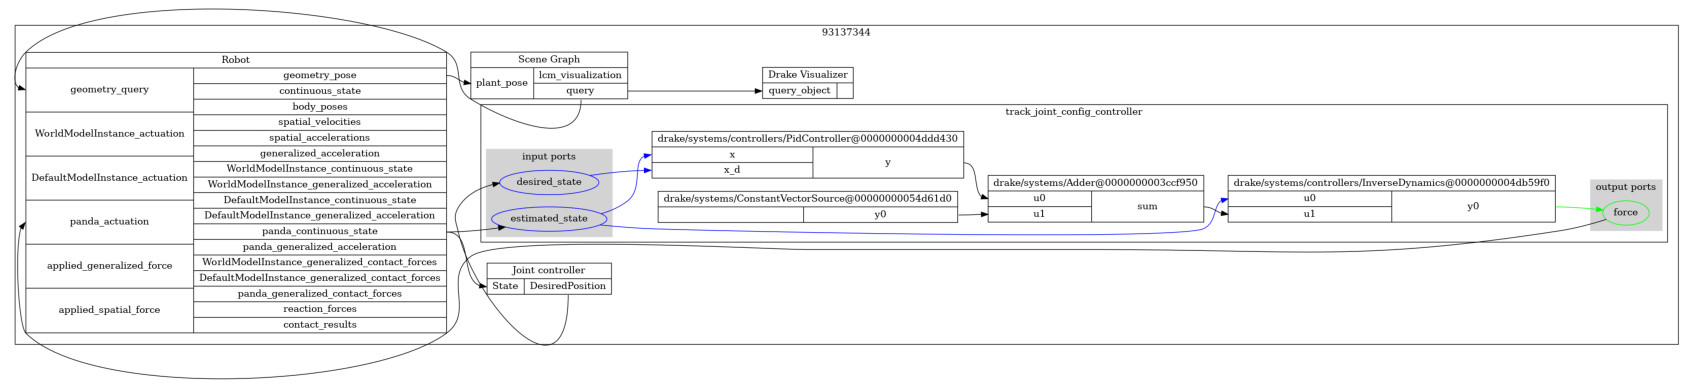

In [50]:
# server_args = []#['--ngrok_http_tunnel']
# proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)


builder = DiagramBuilder()

#Add scene grapher and multibody plant
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
plant.set_name("Robot")
scene_graph.set_name("Scene Graph")
panda_model = Parser(plant, scene_graph).AddModelFromFile(FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()



vis = DrakeVisualizer.AddToBuilder(builder, scene_graph)
vis.set_name("Drake Visualizer")
#meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)


# ---- PID control ----
Kp = np.full(9, 100)
Ki = 2 * np.sqrt(Kp)
Kd = np.full(9, 1)
panda_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
panda_controller.set_name("track_joint_config_controller")
builder.Connect(plant.get_state_output_port(panda_model),
                panda_controller.get_input_port_estimated_state())
builder.Connect(panda_controller.get_output_port_control(),
                plant.get_actuation_input_port())

# Our Controlelr
joint_controller = builder.AddSystem(JointController())
joint_controller.set_name("Joint controller")
builder.Connect(joint_controller.get_output_port(0), panda_controller.GetInputPort('desired_state'))
builder.Connect(plant.get_state_output_port(panda_model),joint_controller.get_input_port())

diagram = builder.Build()

plt.figure(figsize=(30, 30))
plot_system_graphviz(diagram)


In [51]:


context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0, 0])
# x0 = np.hstack((q0, 0*q0))
plant.SetPositions(plant_context, q0)
#panda_controller.GetInputPort('desired_state').FixValue(
#    panda_controller.GetMyMutableContextFromRoot(context), x0)

eePose = plant.EvalBodyPoseInWorld(plant_context,plant.GetBodyByName("panda_hand")).translation()


simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
#vis.start_recording()
simulator.AdvanceTo(5.0)
#vis.stop_recording()


[-1.57  0.1   0.   -1.2   0.    1.6   0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.  ]
